In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, LineString

#other library
import ast
from math import radians, cos, sin, asin, sqrt 
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


import seaborn as sns
from matplotlib import style
style.use('seaborn-darkgrid')

# import folium

import ast

%matplotlib inline

# Trip Data Preperation

In [2]:
def high_trip_volume_days():
    data = pd.read_csv('_Data/trip data/trip_dataset.csv')#, nrows=2000)  #.sample(5000)

    #     #sample small data to test code BUT comment out for final script
    #empty dictionary to track removed trips
    data_count = {'Number of trips before slicing date: ': len(data)}

    #---------------------------------------------------------------------------------------------------------------
    #CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
    #drop row with null startDateTime and endDateTime
    data = data.dropna(subset=['startDate', 'startTime', 'endDate', 'endTime'])
    data['startDateTime'] = data.apply(lambda x: pd.to_datetime(
        x['startDate'][:10] + ' ' + x['startTime'][:8],
        format='%Y-%m-%d %H:%M:%S',
        utc=True).tz_convert('US/Central'),
                                       axis=1)
    data['start_date_str'] = data.apply(
        lambda x: str(x['startDateTime'].date()), axis=1)


    # data_count = data.set_index('startDateTime')[['tripDuration'#,'route_directness_trace','tripDuration_m'#, 'distance_GPS_trace_miles'
    # ]].groupby().resample('D').count()
    return data['start_date_str'].value_counts(ascending=False)

# high_trip_volume_days_sorted=high_trip_volume_days()
# high_trip_volume_days_sorted[:15].index
# high_trip_volume_days_sorted[:15]

In [4]:
data = pd.read_csv('_Data/trip data/trip_dataset.csv')#, nrows=2000)  #.sample(5000)

#---------------------------------------------------------------------------------------------------------------
#CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
#drop row with null startDateTime and endDateTime
data = data.dropna(subset=['startDate', 'startTime', 'endDate', 'endTime'])
# data['startDateTime'] = data.apply(lambda x: pd.to_datetime(
#     x['startDate'][:10] + ' ' + x['startTime'][:8],
#     format='%Y-%m-%d %H:%M:%S',
#     utc=True).tz_convert('US/Central'),
#                                    axis=1)

In [7]:

for operator in data['companyName'].unique():
    
    
    data_operator=data[data['companyName']==operator]
    print(operator, len(data_operator))
    data_operator_sample=data_operator.sample(100)
    
    data_operator_sample.to_csv(str('_Data/trip data/time check/' + operator +
            '_100SampleData.csv'))
    
    

Bird 480403
Lime 765020
Lyft 233703
SPIN 46668
JUMP 13698
Gotcha 3316
Bolt Mobility 27980


In [3]:
def convert_AssumedUTC_to_AssumeCentral(trip_Central):
    '''
    This function converts assumed UTC to assumed Central time zone
    '''

    #convert Assumed UTC and converted Central back to UTC
    trip_starttime_AssumeUTC_InCentral = pd.to_datetime(trip_Central, utc=True)
    #     print('Local (Assumed UTC in Central)', trip_starttime_AssumeUTC_InCentral)

    trip_starttime_AssumeUTC_CorrectedCentral = trip_starttime_AssumeUTC_InCentral.tz_localize(
        None).tz_localize('US/Central', nonexistent='NaT', ambiguous='NaT')
    #     print('Local (Assumed UTC in Central) converted to Central',
    #           trip_starttime_AssumeUTC_CorrectedCentral)

    return trip_starttime_AssumeUTC_CorrectedCentral



In [4]:
# data = pd.read_csv('_Data/trip data/trip_dataset.csv').sample(10000)
#     #                        ,nrows=2000)  # .sample(5000)

#     #     #sample small data to test code BUT comment out for final script
#     # empty dictionary to track removed trips
# data_count = {'Number of trips before slicing date: ': len(data)}

# # ---------------------------------------------------------------------------------------------------------------
# # CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
# # drop row with null startDateTime and endDateTime
# data = data.dropna(subset=['startDate', 'startTime', 'endDate', 'endTime'])
# data['startDateTime'] = data.apply(lambda x: pd.to_datetime(
#     x['startDate'][:10] + ' ' + x['startTime'][:8],
#     format='%Y-%m-%d %H:%M:%S',
#     utc=True).tz_convert('US/Central'),
#                                    axis=1)
# data['endDateTime'] = data.apply(
#     lambda x: pd.to_datetime(x['endDate'][:10] + ' ' + x['endTime'][:8],
#                              format='%Y-%m-%d %H:%M:%S',
#                              utc=True).tz_convert('US/Central'),
#     axis=1)

# #data['pubTimeStamp_pd'] = data.apply(lambda x: pd.to_datetimetime(x['pubTimeStamp'], format='%Y-%m-%d %H:%M:%S'), axis=1)

# # ------------------------------------------------------------------------------------------------------------------
# # SLICE DATA FROM 2018-9-01 to 2019-8-31
# data = data.loc[(data['startDateTime'] > '2018-9-01')
#                 & (data['startDateTime'] < '2019-8-31')]
# data_count.update({'Total number of trips for analysis period': len(data)})

# #correct lime data
# data['startDateTime_month'] = data.apply(
#     lambda x: x['startDateTime'].strftime('%Y-%m'), axis=1)

# data['startDateTime_corrected'] = data.apply(
#     lambda x: convert_AssumedUTC_to_AssumeCentral(x['startDateTime'])
#     if (x['startDateTime_month'] in [
#         '2019-01', '2019-02', '2019-03', '2019-04'
#     ]) and x['companyName'] == 'Lime' else x['startDateTime'],
#     axis=1)

# data['endDateTime_corrected'] = data.apply(
#     lambda x: convert_AssumedUTC_to_AssumeCentral(x['endDateTime'])
#     if (x['startDateTime_month'] in [
#         '2019-01', '2019-02', '2019-03', '2019-04'
#     ]) and x['companyName'] == 'Lime' else x['endDateTime'],
#     axis=1)
# data.head()
# data[data['companyName']=='Lime'].head()

In [5]:
'''This function reads the raw data and cleans the data based on basic criteria. '''


def basic_cleaning():
    # read raw data file
    data = pd.read_csv('_Data/trip data/trip_dataset.csv')#.sample(10000)
    #                        ,nrows=2000)  # .sample(5000)

    #     #sample small data to test code BUT comment out for final script
    # empty dictionary to track removed trips
    data_count = {'Number of trips before slicing date: ': len(data)}

    # ---------------------------------------------------------------------------------------------------------------
    # CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
    # drop row with null startDateTime and endDateTime
    data = data.dropna(subset=['startDate', 'startTime', 'endDate', 'endTime'])
    data['startDateTime'] = data.apply(lambda x: pd.to_datetime(
        x['startDate'][:10] + ' ' + x['startTime'][:8],
        format='%Y-%m-%d %H:%M:%S',
        utc=True).tz_convert('US/Central'),
                                       axis=1)
    data['endDateTime'] = data.apply(
        lambda x: pd.to_datetime(x['endDate'][:10] + ' ' + x['endTime'][:8],
                                 format='%Y-%m-%d %H:%M:%S',
                                 utc=True).tz_convert('US/Central'),
        axis=1)

    #data['pubTimeStamp_pd'] = data.apply(lambda x: pd.to_datetimetime(x['pubTimeStamp'], format='%Y-%m-%d %H:%M:%S'), axis=1)

    # ------------------------------------------------------------------------------------------------------------------
    # SLICE DATA FROM 2018-9-01 to 2019-8-31
    data = data.loc[(data['startDateTime'] > '2018-9-01')
                    & (data['startDateTime'] < '2019-8-31')]
    data_count.update({'Total number of trips for analysis period': len(data)})

    #correct lime data
    data['startDateTime_month'] = data.apply(
        lambda x: x['startDateTime'].strftime('%Y-%m'), axis=1)

    data['startDateTime'] = data.apply(
        lambda x: convert_AssumedUTC_to_AssumeCentral(x['startDateTime'])
        if (x['startDateTime_month'] in [
            '2019-01', '2019-02', '2019-03', '2019-04'
        ]) and x['companyName'] == 'Lime' else x['startDateTime'],
        axis=1)

    data['endDateTime'] = data.apply(
        lambda x: convert_AssumedUTC_to_AssumeCentral(x['endDateTime'])
        if (x['startDateTime_month'] in [
            '2019-01', '2019-02', '2019-03', '2019-04'
        ]) and x['companyName'] == 'Lime' else x['endDateTime'],
        axis=1)

    initial_trip_len = len(data)

    # rename index column as trip ID
    data = data.reset_index().rename(columns={'index': 'trip_id'})

    # ------------------------------------------------------------------------------------------------------------------
    # PRELIMINARY DATA CLEANING

    # REMOVE MISSING VALUES
    # drop na variables and store remaining number of observation
    len_before = len(data)
    data = data.dropna()
    data_count.update({'Trips with Nan': len_before - len(data)})

    # remove trips whose trip duration is between 1 and 180 minutes inclusive
    len_before = len(data)
    data = data[data['tripDuration'].between(1, 180)]
    data_count.update({
        'Trips with duration other than [1:180] minute':
        len_before - len(data)
    })

    # remove trips whose trip distance is between 1 and 10 miles inclusive
    len_before = len(data)
    data = data[data['tripDistance'].between(1, 10 * 5280)]
    data_count.update({
        'Trips with duration other than [0 :10 miles]':
        len_before - len(data)
    })

    # remove observation with too few GPS trace data
    len_before = len(data)
    data = data[data['tripRoute'].str.len() > 40]
    data_count.update({'Trips with few GPS points': len_before - len(data)})

    # DATA CLEANING BECAUSE OF SOME GLITCH
    # remove special character ("") from the data
    data['tripRoute'] = data.apply(
        lambda x: x['tripRoute'].strip().replace('"', ''), axis=1)

    # REMOVING REDUNDANT COLUMNS AND TRANSFORMING COLUMNS

    # ----------------------------------------------------------------------------------------
    # calcute distance between two WGS points and returns value in ft
    def distance(lat1, lon1, lat2, lon2):
        # https://www.geeksforgeeks.org/program-distance-two-points-earth/

        # The math module contains a function named
        # radians which converts from degrees to radians.
        lon1 = radians(lon1)
        lon2 = radians(lon2)
        lat1 = radians(lat1)
        lat2 = radians(lat2)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * asin(sqrt(a))

        # Radius of earth in kilometers. Use 3956 for miles
        r = 3956

        # calculate the result
        return (c * r * 5280)

    def trip_distance(GPS_trace_data):
        try:
            a = 0
            # remove empty list in tripRoute data
            GPS_trace_data = [x for x in GPS_trace_data if x != []]

            for point_id in np.arange(len(GPS_trace_data) - 1):
                a += distance(GPS_trace_data[point_id][0],
                              GPS_trace_data[point_id][1],
                              GPS_trace_data[point_id + 1][0],
                              GPS_trace_data[point_id + 1][1])
            return a
        except:
            return None

    # function to swap lat and long
    def swap(x):
        coords = list(x.coords)
        coords = [
            Point(t[1], t[0]) for t in coords
        ]  # Swap each coordinate using list comprehension and create Points
        return LineString(coords)

    # ----------------------------------------------------------------------------------------

    # drop columns that are redundant
    data = data.drop(columns=[
        'startDate', 'startTime', 'endDate', 'endTime', 'create_dt',
        'pubTimeStamp'
    ])
    data['tripDistance_miles'] = data.apply(lambda x: x['tripDistance'] / 5280,
                                            axis=1)

    data['euclidean_distance'] = data.apply(
        lambda x: distance(x['startLatitude'], x['startLongitude'], x[
            'endLatitude'], x['endLongitude']),
        axis=1)

    data['distance_GPS_trace'] = data.apply(
        lambda x: trip_distance(ast.literal_eval(x['tripRoute'])), axis=1)

    data['distance_GPS_trace_miles'] = data.apply(
        lambda x: x['distance_GPS_trace'] / 5280, axis=1)

    # dummy variable for trip start time
    data['trip_start_hour_no'] = data.apply(
        lambda x: x['startDateTime'].hour + 1, axis=1)

    data['StartTime_AMPeak'] = data.apply(lambda x: 1 if x[
        'trip_start_hour_no'] > 7 and x['trip_start_hour_no'] <= 10 else 0,
                                          axis=1)
    data['StartTime_Day'] = data.apply(lambda x: 1 if x[
        'trip_start_hour_no'] > 10 and x['trip_start_hour_no'] <= 16 else 0,
                                       axis=1)
    data['StartTime_PMPeak'] = data.apply(lambda x: 1 if x[
        'trip_start_hour_no'] > 16 and x['trip_start_hour_no'] <= 20 else 0,
                                          axis=1)
    data['StartTime_Night'] = data.apply(
        lambda x: 1
        if x['trip_start_hour_no'] > 20 or x['trip_start_hour_no'] <= 7 else 0,
        axis=1)

    data['StartTime_decimal'] = data.apply(
        lambda x: x['startDateTime'].hour + x['startDateTime'].minute / 60,
        axis=1)

    len_before = len(data)
    data = data[data['euclidean_distance'] > 0]

    # -----------------------------
    data_count.update({'Same start and end points': len_before - len(data)})

    #     len_before = len(data)
    data = data[data['distance_GPS_trace'] > 0]
    data_count.update({'zero GPS trace distance': len_before - len(data)})

    # calculate trip directness
    data['route_directness_trace'] = data.apply(
        lambda x: x['euclidean_distance'] / x['distance_GPS_trace'], axis=1)
    # -----------------------------

    data['route_directness_rawDist'] = data.apply(
        lambda x: x['euclidean_distance'] / x['tripDistance'], axis=1)
    # -----------------------------
    len_before = len(data)
    data = data[data['route_directness_trace'] < 1]
    data_count.update({'route directness > 1': len_before - len(data)})
    # -----------------------------
    data['average_trip_speed_mph'] = data.apply(
        lambda x: x['tripDistance'] / (x['tripDuration'] * 60) * 0.681818,
        axis=1)

    # create a variable name with trip start hour and week number (Monday=0 and Sunday=6)
    data['trip_start_week_no'] = data.apply(
        lambda x: x['startDateTime'].weekday(), axis=1)

    def flag_weekend_trip(trip_start_week_no, trip_start_hour_no):
        weekend = 0
        if trip_start_week_no >= 6:
            weekend = 1
        elif (trip_start_week_no == 5) & (trip_start_hour_no > 16):
            weekend = 1

        return weekend

    data['weekend_trip'] = data.apply(lambda x: flag_weekend_trip(
        x['trip_start_week_no'], x['trip_start_hour_no']),
                                      axis=1)

    # trip in high trip count day
    high_trip_day = [
        '2019-04-27', '2019-04-26', '2019-05-25', '2019-05-26', '2019-06-01',
        '2019-04-25', '2019-06-08', '2019-05-18', '2019-04-28', '2019-06-15',
        '2019-04-21', '2019-04-13', '2019-03-23', '2019-04-06', '2019-05-17'
    ]

    data['start_date_str'] = data.apply(
        lambda x: str(x['startDateTime'].date()), axis=1)

    data['high_trip_count_day'] = data.apply(
        lambda x: 1 if x['start_date_str'] in high_trip_day else 0, axis=1)

    data_count.update({'Total number of trips after cleaning': len(data)})
    data_count.update(
        {'Total number of trips removed': initial_trip_len - len(data)})

    # ----------------------------------------------------------------------------
    # save data with all column
    data.to_csv(
        '_Data/trip data/cleaned_trip_data_withRouteData_TimeZoneCorrected_08192021.csv'
    )
    # save data without route data column
    data.drop(columns=['tripRoute']).to_csv(
        '_Data/trip data/cleaned_trip_data_withoutRouteData_TimeZoneCorrected_08192021.csv'
    )
    # data.sample(200000, random_state=0).to_csv(
    #     '../1_Data/trip data/cleaned_sampled_trip_data_withRouteData_sample.csv'
    # )

    # export start and end points with trip_id
    # data[['trip_id', 'startLatitude', 'startLongitude',
    #       'weekend_flag']].to_csv('../1_Data/trip data/start_points.csv')
    # data[['trip_id', 'endLatitude', 'endLongitude',
    #       'weekend_flag']].to_csv('../1_Data/trip data/end_points.csv')

    data[[
        'trip_id', 'startLatitude', 'startLongitude', 'endLatitude',
        'endLongitude', 'weekend_trip', 'startDateTime', 'tripRoute'
    ]].to_csv(
        '_Data/trip data/start_end_points_cleaned_TimeZoneCorrected_08192021.csv'
    )

    return data, data_count

In [6]:
#call function to read and clean the data
(trip_data, count) = basic_cleaning()

## Explore corrected timezone

In [7]:
trip_data.shape

(1072890, 31)

C:\Users\User\.conda\envs\geo_env\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


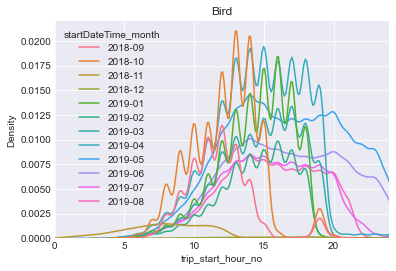

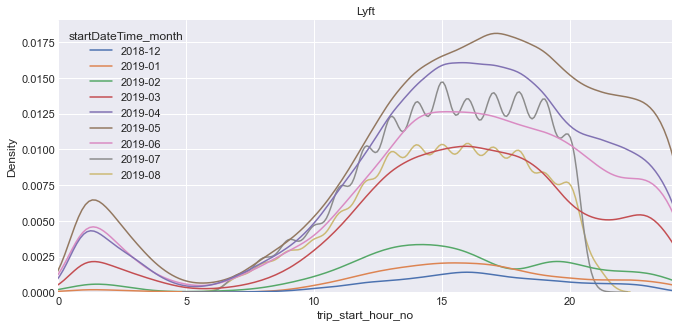

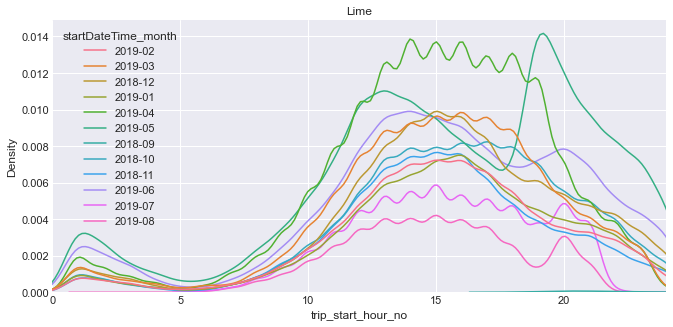

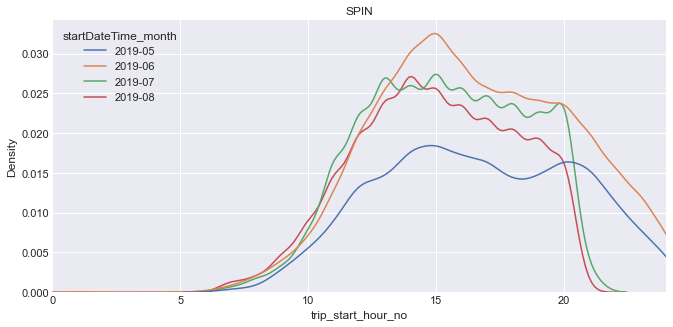

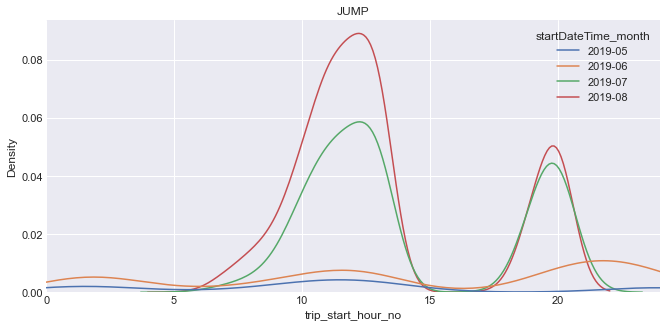

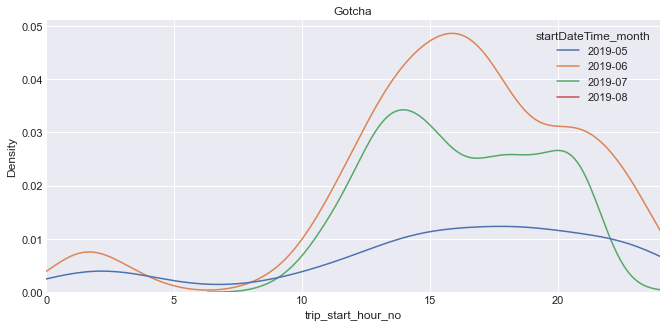

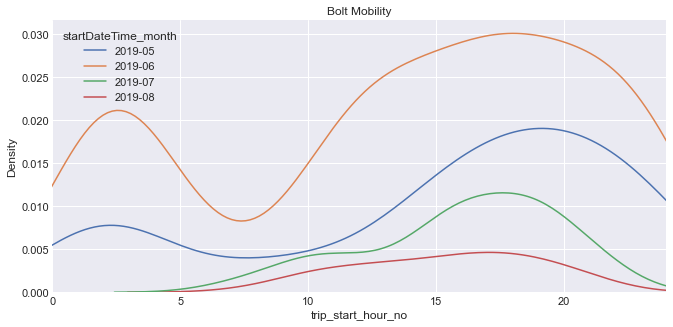

In [8]:
#loop over each operator to plot starttime of the day
for operator in trip_data['companyName'].unique():
    style.use('seaborn-darkgrid')
    plot, ax = plt.subplots()
    plot = sns.kdeplot(data=trip_data[trip_data['companyName'] == operator],
                       x='trip_start_hour_no',
                       hue='startDateTime_month')

    sns.set(rc={'figure.figsize': (11, 5)})
    plot.set(title=operator)
    plot.set(xlim=(0, 24))
    fig = plot.get_figure()
    fig.savefig(
        str('_Data/trip data/time check/' + operator +
            '_kde_afterCorrecting.png'))

## Summary of cleaning

In [9]:
print("lenght of raw data: ",len(trip_data))
print('Cleaning')
count

lenght of raw data:  1072890
Cleaning


{'Number of trips before slicing date: ': 1570815,
 'Total number of trips for analysis period': 1547635,
 'Trips with Nan': 25711,
 'Trips with duration other than [1:180] minute': 127498,
 'Trips with duration other than [0 :10 miles]': 182676,
 'Trips with few GPS points': 9577,
 'Same start and end points': 2611,
 'zero GPS trace distance': 5671,
 'route directness > 1': 123612,
 'Total number of trips after cleaning': 1072890,
 'Total number of trips removed': 474745}

In [10]:
print('percentage of trips removed: ', 474490/1546920*100)

percentage of trips removed:  30.673208698575234


In [11]:
trip_data[['startDateTime', 'endDateTime',]].head() #verifyied that datetime is corrected

,startDateTime,endDateTime
1,2018-09-01 07:13:22-05:00,2018-09-01 07:20:14-05:00
2,2018-09-01 07:14:46-05:00,2018-09-01 07:49:27-05:00
3,2018-09-01 07:15:11-05:00,2018-09-01 07:51:44-05:00
4,2018-09-01 07:46:21-05:00,2018-09-01 08:07:25-05:00
5,2018-09-01 07:18:32-05:00,2018-09-01 08:10:33-05:00


# Additional data

## Link points to GRID_ID

In [12]:
#read data
grid_gdf = gpd.read_file("_Data/Landuse data/Shapefiles/Fishnet_250m_selectedGrids.shp")
trip_df=pd.read_csv("_Data/trip data/start_end_points_cleaned_TimeZoneCorrected_08192021.csv")

In [13]:
def link_startpoint_grid(points_df):
    # creating a geometry column
    geometry_start = [
        Point(xy)
        for xy in zip(points_df['startLongitude'], points_df['startLatitude'])
    ]

    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}

    # Creating a Geographic data frame
    startpoints_gdf = gpd.GeoDataFrame(points_df,
                                       crs=crs,
                                       geometry=geometry_start)

    #join points

    startpoints_merged = gpd.sjoin(startpoints_gdf,
                                   grid_gdf,
                                   how="left",
                                   op='intersects')
    startpoints_merged = startpoints_merged[['trip_id', 'GRID_ID']]

    return pd.DataFrame(startpoints_merged).rename(columns={'GRID_ID':'GRID_ID_start'})

def link_endpoint_grid(points_df):
    # creating a geometry column
    geometry_end = [
        Point(xy)
        for xy in zip(points_df['endLongitude'], points_df['endLatitude'])
    ]

    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}

    # Creating a Geographic data frame
    endpoints_gdf = gpd.GeoDataFrame(points_df, crs=crs, geometry=geometry_end)

    #join ebd points
    endpoints_merged = gpd.sjoin(endpoints_gdf,
                                 grid_gdf,
                                 how="left",
                                 op='intersects')
    endpoints_merged = endpoints_merged[['trip_id', 'GRID_ID']]

    return pd.DataFrame(endpoints_merged).rename(columns={'GRID_ID':'GRID_ID_end'})


#call function
startpoint_grids = link_startpoint_grid(trip_df[['trip_id', 'startLatitude', 'startLongitude']])
endpoint_grids = link_endpoint_grid(trip_df[['trip_id', 'endLatitude', 'endLongitude']])

#create a dataframe that links trip_id with start and end points
startend_grid= pd.merge(startpoint_grids,endpoint_grids, on='trip_id', how='inner').dropna()

C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-13-f8b94716baa5>:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  startpoints_merged = gpd.sjoin(startpoints_gdf,
C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pypr

In [14]:
count.update({'Trips dropped for missing value in GRID': len(trip_data)-len(startend_grid)})
print('Number of trips dropped: ',len(trip_data)-len(startend_grid))


Number of trips dropped:  22393


## Link grid level data

### Read data

In [15]:
landuse_byGrid = pd.DataFrame(
    gpd.read_file(
        '_Data/Landuse data/results/Shapefile/LanduseData_ByGrid.shp')
).drop(
    columns=['OBJECTID', 'Shape_Leng', 'Shape_Area', 'Sum_BuiltE', 'geometry'
             ]).rename(columns={'Fishnet_25': 'GRID_ID'})
#average short and long term parking
landuse_byGrid['MEAN_PAKING'] = landuse_byGrid[['MEAN_SHT_P','MEAN_LNG_P']].mean(axis=1)
landuse_byGrid=landuse_byGrid.drop(columns=['MEAN_SHT_P','MEAN_LNG_P'])

enthropy_byGrid = pd.read_csv(
    '_Data/Landuse data/results/enthropy_value.csv')[[
        'Fishnet_25', 'enthropy'
    ]].rename(columns={'Fishnet_25': 'GRID_ID'})

intersection_density_byGrid = pd.read_csv(
    '_Data/Landuse data/results/intersection_density.csv')[[
        'GRID_ID', 'intersection_density'
    ]]

### Join data

In [16]:
#Merge by joining columns to startend_grid dataframe 
#start points
#enthropy
landuse_merged = pd.merge(startend_grid,
                          enthropy_byGrid.add_suffix('_start'),
                          left_on='GRID_ID_start',
                          right_on='GRID_ID_start',
                          how='left')  

#landuse
landuse_merged = pd.merge(landuse_merged,
                          landuse_byGrid.add_suffix('_start'),
                          left_on='GRID_ID_start',
                          right_on='GRID_ID_start',
                          how='left') 
#intersection density
landuse_merged = pd.merge(landuse_merged,
                          intersection_density_byGrid.add_suffix('_start'),
                          left_on='GRID_ID_start',
                          right_on='GRID_ID_start',
                          how='left') 

##End points
#enthropy
landuse_merged = pd.merge(landuse_merged,
                          enthropy_byGrid.add_suffix('_end'),
                          left_on='GRID_ID_end',
                          right_on='GRID_ID_end',
                          how='left')  

#landuse
landuse_merged = pd.merge(landuse_merged,
                          landuse_byGrid.add_suffix('_end'),
                          left_on='GRID_ID_end',
                          right_on='GRID_ID_end',
                          how='left') 
#intersection density
landuse_merged = pd.merge(landuse_merged,
                          intersection_density_byGrid.add_suffix('_end'),
                          left_on='GRID_ID_end',
                          right_on='GRID_ID_end',
                          how='left') 

print(landuse_merged.shape)
landuse_merged.head()

(1050497, 21)


,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,MEAN_EMP_D_start,...,intersection_density_start,enthropy_end,MEAN_CBD_end,MEAN_URBAN_end,MEAN_SU_end,MEAN_RURAL_end,MEAN_POP_D_end,MEAN_EMP_D_end,MEAN_PAKING_end,intersection_density_end
0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,188334.483817,...,621.597144,-0.000000,0.80,0.10,0.0,0.0,530.609222,3665.007690,0.000000,196.839096
1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,9999.931152,...,590.517287,0.564575,0.70,0.20,0.0,0.0,5693.230387,14719.494466,1559.211149,517.997620
2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,455.837906,0.534311,0.35,0.55,0.0,0.0,4636.734375,24489.909180,2307.121338,248.638858
3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,86548.495056,...,714.836716,0.928214,0.90,0.00,0.0,0.0,15831.781111,188334.483817,36130.608957,621.597144
4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,455.837906,0.534311,0.35,0.55,0.0,0.0,4636.734375,24489.909180,2307.121338,248.638858


## Link trip level data

### Flag locations

In [17]:
park_shp=gpd.read_file(
        '_Data/Landuse data/results/Shapefile/Park.shp')
vanderbilt_shp=gpd.read_file(
        '_Data/Landuse data/results/Shapefile/Vanderbilt_University.shp')
nissan_shp=gpd.read_file(
        '_Data/Landuse data/results/Shapefile/Nissan_stadium.shp')

In [18]:
def link_startpoint_flag(points_df, flag_shp,col_name):
    # creating a geometry column
    geometry_start = [
        Point(xy)
        for xy in zip(points_df['startLongitude'], points_df['startLatitude'])
    ]

    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}

    # Creating a Geographic data frame
    startpoints_gdf = gpd.GeoDataFrame(points_df,
                                       crs=crs,
                                       geometry=geometry_start)

    #join points

    startpoints_merged = gpd.sjoin(startpoints_gdf,
                                   flag_shp,
                                   how="left",
                                   op='intersects')
    startpoints_merged = startpoints_merged[['trip_id', col_name]]
    start_point_pd = pd.DataFrame(startpoints_merged)
    start_point_pd[col_name]=start_point_pd[col_name].fillna(0)
    
    return start_point_pd

link_park_start=link_startpoint_flag(trip_df[['trip_id', 'startLatitude', 'startLongitude']], park_shp,'PARK')

link_vanderbilt_start = link_startpoint_flag(
    trip_df[['trip_id', 'startLatitude', 'startLongitude']], vanderbilt_shp, 'VANDERBILT')

link_nissan_start = link_startpoint_flag(
    trip_df[['trip_id', 'startLatitude', 'startLongitude']], nissan_shp,
    'NFL_DRAFT').rename(columns={'NFL_DRAFT': 'NISSAN'})

C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-18-1fceb8189e4e>:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  startpoints_merged = gpd.sjoin(startpoints_gdf,
C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pypr

In [19]:
#link trip data for starts
landuse_merged = pd.merge(landuse_merged,
                          link_park_start.add_suffix('_start'),
                          left_on='trip_id',
                          right_on='trip_id_start',
                          how='left').drop(columns=['trip_id_start'])

landuse_merged = pd.merge(landuse_merged,
                          link_vanderbilt_start.add_suffix('_start'),
                          left_on='trip_id',
                          right_on='trip_id_start',
                          how='left').drop(columns=['trip_id_start'])

landuse_merged = pd.merge(landuse_merged,
                          link_nissan_start.add_suffix('_start'),
                          left_on='trip_id',
                          right_on='trip_id_start',
                          how='left').drop(columns=['trip_id_start'])

In [20]:
def link_endpoint_grid(points_df, flag_shp, col_name):
    # creating a geometry column
    geometry_end = [
        Point(xy)
        for xy in zip(points_df['endLongitude'], points_df['endLatitude'])
    ]

    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}

    # Creating a Geographic data frame
    endpoints_gdf = gpd.GeoDataFrame(points_df, crs=crs, geometry=geometry_end)

    #join points

    endpoints_merged = gpd.sjoin(endpoints_gdf,
                                 flag_shp,
                                 how="left",
                                 op='intersects')
    endpoints_merged = endpoints_merged[['trip_id', col_name]]
    end_point_pd = pd.DataFrame(endpoints_merged)
    end_point_pd[col_name] = end_point_pd[col_name].fillna(0)

    return end_point_pd


link_park_end = link_endpoint_grid(
    trip_df[['trip_id', 'endLatitude', 'endLongitude']], park_shp, 'PARK')

link_vanderbilt_end = link_endpoint_grid(
    trip_df[['trip_id', 'endLatitude', 'endLongitude']], vanderbilt_shp,
    'VANDERBILT')

link_nissan_end = link_endpoint_grid(
    trip_df[['trip_id', 'endLatitude', 'endLongitude']], nissan_shp,
    'NFL_DRAFT').rename(columns={'NFL_DRAFT': 'NISSAN'})

C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-20-b45fa0eee927>:16: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  endpoints_merged = gpd.sjoin(endpoints_gdf,
C:\Users\User\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/s

In [21]:
#link trip data for ends
landuse_merged = pd.merge(landuse_merged,
                          link_park_end.add_suffix('_end'),
                          left_on='trip_id',
                          right_on='trip_id_end',
                          how='left').drop(columns=['trip_id_end'])

landuse_merged = pd.merge(landuse_merged,
                          link_vanderbilt_end.add_suffix('_end'),
                          left_on='trip_id',
                          right_on='trip_id_end',
                          how='left').drop(columns=['trip_id_end'])

landuse_merged = pd.merge(landuse_merged,
                          link_nissan_end.add_suffix('_end'),
                          left_on='trip_id',
                          right_on='trip_id_end',
                          how='left').drop(columns=['trip_id_end'])
print(landuse_merged.shape)
landuse_merged.head()

(1050497, 27)


,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,MEAN_EMP_D_start,...,MEAN_POP_D_end,MEAN_EMP_D_end,MEAN_PAKING_end,intersection_density_end,PARK_start,VANDERBILT_start,NISSAN_start,PARK_end,VANDERBILT_end,NISSAN_end
0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,188334.483817,...,530.609222,3665.007690,0.000000,196.839096,0.0,0.0,0.0,0.0,0.0,1.0
1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,9999.931152,...,5693.230387,14719.494466,1559.211149,517.997620,0.0,0.0,0.0,1.0,0.0,0.0
2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,4636.734375,24489.909180,2307.121338,248.638858,0.0,0.0,0.0,0.0,0.0,0.0
3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,86548.495056,...,15831.781111,188334.483817,36130.608957,621.597144,0.0,0.0,0.0,0.0,0.0,0.0
4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,4636.734375,24489.909180,2307.121338,248.638858,0.0,0.0,0.0,0.0,0.0,0.0


### Weather data

In [22]:
weather_data = pd.read_excel(
    io='_Data/weather data/NashvilleAirport_data.xlsx')

# trip_data['start_date_str'] = trip_data.apply(
#     lambda x: str(x['startDateTime'].date()), axis=1)
weather_data['DATE_str'] = weather_data.apply(lambda x: str(x['DATE'].date()),
                                              axis=1)

weather_data=weather_data[['DATE_str','PRCP','TAVG']]
weather_data

,DATE_str,PRCP,TAVG
0,2018-09-01,0.02,79
1,2018-09-02,0.00,81
2,2018-09-03,0.00,83
3,2018-09-04,0.00,83
4,2018-09-05,0.00,81
...,...,...,...
360,2019-08-27,0.00,77
361,2019-08-28,0.00,78
362,2019-08-29,0.00,73
363,2019-08-30,0.00,76


# Merging datasets

In [23]:
#column names in trip data
trip_data.columns

Index(['trip_id', 'companyName', 'tripRecordNum', 'sumdID', 'tripDuration',
       'tripDistance', 'startLatitude', 'startLongitude', 'endLatitude',
       'endLongitude', 'tripRoute', 'startDateTime', 'endDateTime',
       'startDateTime_month', 'tripDistance_miles', 'euclidean_distance',
       'distance_GPS_trace', 'distance_GPS_trace_miles', 'trip_start_hour_no',
       'StartTime_AMPeak', 'StartTime_Day', 'StartTime_PMPeak',
       'StartTime_Night', 'StartTime_decimal', 'route_directness_trace',
       'route_directness_rawDist', 'average_trip_speed_mph',
       'trip_start_week_no', 'weekend_trip', 'start_date_str',
       'high_trip_count_day'],
      dtype='object')

In [24]:
#select columns
trip_data_selected = trip_data[[
    'trip_id', 'tripDistance_miles', 'tripDistance', 'tripDuration', 'euclidean_distance', 'StartTime_decimal',
    'route_directness_rawDist','route_directness_trace', 'average_trip_speed_mph', 'trip_start_week_no',
    'trip_start_hour_no', 'StartTime_AMPeak', 'StartTime_Day',
    'StartTime_PMPeak', 'StartTime_Night', 'weekend_trip', 'start_date_str',
    'high_trip_count_day'
]]

In [25]:
#merge lanuse and trip data
landuse_trip_df=pd.merge(landuse_merged,
         trip_data_selected,
         left_on='trip_id',
         right_on='trip_id',
         how='left')
print(landuse_trip_df.shape)
landuse_trip_df.head()

(1050497, 44)


,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,MEAN_EMP_D_start,...,average_trip_speed_mph,trip_start_week_no,trip_start_hour_no,StartTime_AMPeak,StartTime_Day,StartTime_PMPeak,StartTime_Night,weekend_trip,start_date_str,high_trip_count_day
0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,188334.483817,...,11.376416,5,8,1,0,0,0,0,2018-09-01,0
1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,9999.931152,...,7.296671,5,8,1,0,0,0,0,2018-09-01,0
2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,8.265578,5,8,1,0,0,0,0,2018-09-01,0
3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,86548.495056,...,0.150904,5,8,1,0,0,0,0,2018-09-01,0
4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,5.066086,5,8,1,0,0,0,0,2018-09-01,0


In [26]:
#merge weather data
landuse_trip_weather_df=pd.merge(landuse_trip_df,
         weather_data,
         left_on='start_date_str',
         right_on='DATE_str',
         how='left').drop(columns=['start_date_str'])
print(landuse_trip_weather_df.shape)
landuse_trip_weather_df.head()

(1050497, 46)


,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,MEAN_EMP_D_start,...,trip_start_hour_no,StartTime_AMPeak,StartTime_Day,StartTime_PMPeak,StartTime_Night,weekend_trip,high_trip_count_day,DATE_str,PRCP,TAVG
0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,188334.483817,...,8,1,0,0,0,0,0,2018-09-01,0.02,79
1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,9999.931152,...,8,1,0,0,0,0,0,2018-09-01,0.02,79
2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,8,1,0,0,0,0,0,2018-09-01,0.02,79
3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,86548.495056,...,8,1,0,0,0,0,0,2018-09-01,0.02,79
4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,207176.091278,...,8,1,0,0,0,0,0,2018-09-01,0.02,79


# Check data

In [27]:
#missing data
landuse_trip_weather_df.isna().sum()

trip_id                           0
GRID_ID_start                     0
GRID_ID_end                       0
enthropy_start                24782
MEAN_CBD_start                    0
MEAN_URBAN_start                  0
MEAN_SU_start                     0
MEAN_RURAL_start                  0
MEAN_POP_D_start                  0
MEAN_EMP_D_start                  0
MEAN_PAKING_start                 0
intersection_density_start        0
enthropy_end                  32043
MEAN_CBD_end                      0
MEAN_URBAN_end                    0
MEAN_SU_end                       0
MEAN_RURAL_end                    0
MEAN_POP_D_end                    0
MEAN_EMP_D_end                    0
MEAN_PAKING_end                   0
intersection_density_end          0
PARK_start                        0
VANDERBILT_start                  0
NISSAN_start                      0
PARK_end                          0
VANDERBILT_end                    0
NISSAN_end                        0
tripDistance_miles          

The corrosponding GRIDs of na values of enthropy have no POI. The enthropy of such grid is zero. Therefore, we can replace missing values with 0


In [28]:
landuse_trip_weather_df=landuse_trip_weather_df.fillna(0)

# Summary

In [29]:
count

{'Number of trips before slicing date: ': 1570815,
 'Total number of trips for analysis period': 1547635,
 'Trips with Nan': 25711,
 'Trips with duration other than [1:180] minute': 127498,
 'Trips with duration other than [0 :10 miles]': 182676,
 'Trips with few GPS points': 9577,
 'Same start and end points': 2611,
 'zero GPS trace distance': 5671,
 'route directness > 1': 123612,
 'Total number of trips after cleaning': 1072890,
 'Total number of trips removed': 474745,
 'Trips dropped for missing value in GRID': 22393}

In [30]:
print('percentage of trips removed for missing GRID', 22389/1546920*100)
print('number of trips removed overall', 1546920-1050041)
print('percentage of trips removed overall', 100-1050041/1546920*100)


percentage of trips removed for missing GRID 1.4473275928942673
number of trips removed overall 496879
percentage of trips removed overall 32.120536291469506


In [31]:
landuse_trip_weather_df.columns

Index(['trip_id', 'GRID_ID_start', 'GRID_ID_end', 'enthropy_start',
       'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_SU_start',
       'MEAN_RURAL_start', 'MEAN_POP_D_start', 'MEAN_EMP_D_start',
       'MEAN_PAKING_start', 'intersection_density_start', 'enthropy_end',
       'MEAN_CBD_end', 'MEAN_URBAN_end', 'MEAN_SU_end', 'MEAN_RURAL_end',
       'MEAN_POP_D_end', 'MEAN_EMP_D_end', 'MEAN_PAKING_end',
       'intersection_density_end', 'PARK_start', 'VANDERBILT_start',
       'NISSAN_start', 'PARK_end', 'VANDERBILT_end', 'NISSAN_end',
       'tripDistance_miles', 'tripDistance', 'tripDuration',
       'euclidean_distance', 'StartTime_decimal', 'route_directness_rawDist',
       'route_directness_trace', 'average_trip_speed_mph',
       'trip_start_week_no', 'trip_start_hour_no', 'StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night', 'weekend_trip',
       'high_trip_count_day', 'DATE_str', 'PRCP', 'TAVG'],
      dtype='object')

# Save data for model

In [32]:
landuse_trip_weather_df.to_csv(
    '_Data/model data/model_data_TimeZoneCorrected_08192021.csv')
# landuse_trip_weather_df.sample(
#     5000, random_state=0).to_csv('_Data/model data/model_data_sample.csv')